In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn import feature_extraction

# Custom Python Files
from dataPrep import cleanData
from modelPrep import model_prep
from modelPrep import plotROCCurve

In [15]:
#xcols = ['admins', 'employees', 'usecompetitors','contractdays', 'callcycle', 'associateddeals','timescontacted','sessions', 'FF', 'strategic']

xcols = ['usecompetitors', 'callcycle','sessions', 'FF', 'strategic']

ycol = "churn"

df = cleanData("PSCCustomerData.csv")

X, y, xcolnames = model_prep(df,xcols,ycol, standardize=False)

In [16]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X,y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [17]:
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))

Logistic Regression:           0.82


### Logistic Regression Deep Dive

In [18]:
# Hyper parameter tuning

#Grid Search
logreg = linear_model.LogisticRegression(class_weight='balanced', solver="liblinear")
param = {'C':[0.001,0.01, 0.5, 0.6, 0.8,1,9,10,11]}
clf = model_selection.GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=5)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.7817, with best C: {'C': 10}


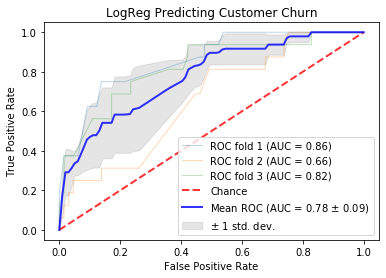

In [19]:
seed = 1234

# Model building and KFold
lr = linear_model.LogisticRegression(class_weight='balanced', penalty='none', max_iter=10000)
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

# initialization params
pred_test_full = y.copy()
cv_score =[]
i=1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for train_index,test_index in kf.split(X,y):
    xtr,xvl = X[train_index],X[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    #fit model
    lr.fit(xtr,ytr)

    #get prediction data
    pred_test = lr.predict_proba(xvl)[:,1]
    pred_test_full[yvl] = lr.predict_proba(xvl)[:,1]

    # ROC Curve Plotting
    viz = plot_roc_curve(lr, xvl, yvl,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    i+=1

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="LogReg Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()

### Variable Importance Metrics

In [20]:
from statsmodels.discrete import discrete_model as sm

logit = sm.Logit(y, X)

# fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.360329
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  242
Model:                          Logit   Df Residuals:                      233
Method:                           MLE   Df Model:                            8
Date:                Thu, 20 Feb 2020   Pseudo R-squ.:                  0.2766
Time:                        18:48:57   Log-Likelihood:                -87.200
converged:                       True   LL-Null:                       -120.54
Covariance Type:            nonrobust   LLR p-value:                 2.242e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8306      0.505      1.644      0.100      -0.159       1.821
x2            -0.1417      0

In [21]:
xcolnames

Index(['usecompetitors', 'sessions', 'FF', 'strategic',
       'callcycle_Every Other Month', 'callcycle_Half Year',
       'callcycle_Monthly', 'callcycle_Quarterly', 'callcycle_Yearly'],
      dtype='object')

### Variable Importance through Coefficients

In [22]:
logreg_full = linear_model.LogisticRegression(class_weight='balanced', penalty='none').fit(X, y)
pred_full = logreg_full.predict_proba(X)[:,1]

prob = (np.exp(logreg_full.coef_) - 1)

pd.DataFrame(np.round(prob.T,2), index=xcolnames, columns=["% Change"]).sort_values(by="% Change", ascending=False)

,% Change
callcycle_Quarterly,6.42
FF,2.19
usecompetitors,1.26
callcycle_Every Other Month,0.64
callcycle_Monthly,0.00
sessions,-0.15
callcycle_Yearly,-0.43
callcycle_Half Year,-0.79
strategic,-0.94


#### Variable Importance through RFE

In [13]:
from sklearn.feature_selection import RFE

selector = RFE(logreg_full, n_features_to_select=1)
selector.fit(X, y)

order = np.array(selector.ranking_)

pd.DataFrame(order.T, index=xcolnames, columns=["Rank"]).sort_values(by="Rank")

,Rank
strategic,1
callcycle_Half Year,2
callcycle_Yearly,3
usecompetitors,4
callcycle_Monthly,5
callcycle_Every Other Month,6
FF,7
callcycle_Quarterly,8
sessions,9
